## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pydicom as dicom

# use this to change which GPU to use
gpu = 0

# set the modified tf session as backend in keras
setup_gpu(gpu)

Using TensorFlow backend.


## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = r'D:\Studying\RetinaNet_snapshots\12_06_2020_no_random_transform\convert_40.h5'

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


c:\anaconda\envs\tf_lower_version\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model: "retinanet-bbox"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
_____________________________________________________________________________________

In [3]:
# load label to names mapping for visualization purposes
# This field is for the COCO database case. For OID case, please use the labels (500 in total) in the next cell.
labels_to_names = {0: 'mass'}

## Run detection on example

In [5]:
# Read medical image here.

file_name = r'D:\Studying\RetinaNet_Project\all_DICOM_files\AllDICOMs\22614522_2dec4948fbe6336d_MG_L_CC_ANON.dcm'
dicom_data = dicom.dcmread(file_name)
dicom_data = dicom_data.pixel_array

image = read_image_bgr(file_name)

In [6]:
# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image, min_side = 1700, max_side = 2300)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)
print('boxes:', boxes)


processing time:  7.774890184402466
boxes: [[[ 9.22898712e+01  2.09932526e+02  2.33186966e+02  3.65505249e+02]
  [ 4.85836182e+02  1.42469080e+03  5.90453918e+02  1.55481445e+03]
  [ 1.08059166e+02  2.60054291e+02  2.38843552e+02  4.01881927e+02]
  ...
  [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
  [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
  [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]]]


In [7]:
print(boxes.shape)
print(scores.shape)
print(labels.shape)
print(scores)
print(labels)

(1, 300, 4)
(1, 300)
(1, 300)
[[ 0.84786224  0.15272784  0.06784385  0.06276622  0.05971062  0.05879223
   0.05376267  0.05262926 -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         

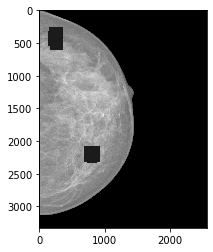

In [17]:
box = boxes[0,10,:] / scale
cv2.rectangle(dicom_data, (box[0], box[1]), (box[2], box[3]), (255,0,0), -1)
plt.imshow(dicom_data, cmap='gray')


c:\anaconda\envs\tf_lower_version\lib\site-packages\keras_retinanet\utils\colors.py:18: UserWarning: Label 121 has no color, returning default.
  warnings.warn('Label {} has no color, returning default.'.format(label))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


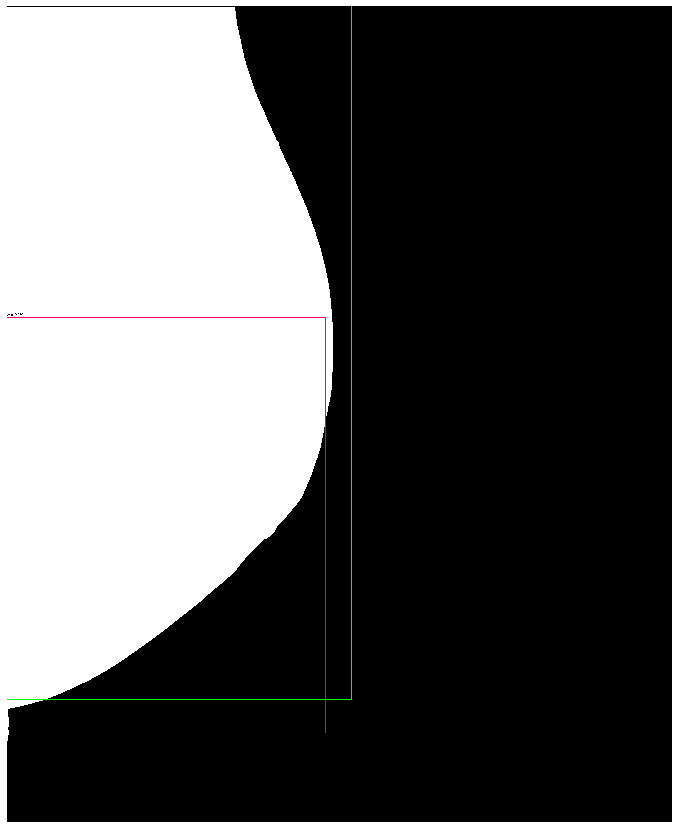

In [7]:
# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.54:
        break
        
#     color = label_color(label)
    
#     b = box.astype(int)
#     draw_box(image_rbg, b, color=color)
    
#     caption = "{} {:.3f}".format(labels_to_names[label], score)
#     draw_caption(image_rbg, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(image_rbg)
plt.show()